# Search Evaluation Notebook

This python notebook will perform a search evaluation 
Prerequisites:
* Golden data set in file ```golden_data.csv```
* Search strategies in python modules located in the ```strategies``` folder

In [1]:
import requests
from io import StringIO
from dotenv import load_dotenv
import os, subprocess



# # Export the API key to an environment variable
# if not os.path.exists('.env.instruqt'):
#     env_text = requests.get('http://kubernetes-vm:9000/env').text
#     with open('.env.instruqt', 'w') as f:
#         f.write(env_text)
# load_dotenv('.env.instruqt')

# openai_api_key =  os.environ.get("LLM_APIKEY") 
# url = os.environ.get("LLM_PROXY_URL") 
# openai_api_base = f"https://{url}"

# os.environ["OPENAI_API_KEY"] = openai_api_key
# os.environ["OPENAI_BASE_URL"] = openai_api_base

# subprocess.run([
#     "deepeval", "set-local-model", 
#     "--model-name=eval-gpt-4o", ## needs azure 2024-11-20 +
#     f"--base-url={openai_api_base}", 
#     f"--api-key={openai_api_key}"
#     f""])

# ## Uncomment the following lines if you want to use .env file to control settings
load_dotenv()   


True

In [2]:
### What files to work with
GOLDEN_DATA_CSV = "wikivoyage_judgement_list.csv"
STRATEGIES_FOLDER = "strategies"
SEARCH_OUTPUT_JSON = "results_search_evaluation.json"
DEEPEVAL_OUTPUT_JSON = "results_deepeval_results.json"

In [3]:
## Run the Evaluation

from utility.util_es import get_es
from utility.util_vis_result import vis_search_eval_json, vis_deep_eval_correct_tests
from evaluate import run_search_evaluation, load_golden_data, load_strategies, output_search_eval_results

# https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html
print("### Starting evaluation using Elasticsearch _rank_eval API")

# 1. Connect to Elasticsearch
es = get_es()
print(f"\tConnected to Elasticsearch version: {es.info()['version']['number']}")

# 2. Load the golden data set
golden_data = load_golden_data(GOLDEN_DATA_CSV)
print(f"\tIdentified {len(golden_data)} golden data entry(ies) to use for search evaluation")

# 3. Load strategies from the strategies folder
strategy_modules = load_strategies(STRATEGIES_FOLDER)  
print(f"\tIdentified {len(strategy_modules)} strategy(ies) to evaluate")

# 4. Evaluate each strategy
results = run_search_evaluation(es, golden_data, strategy_modules)

# 5. Output the evaluation results
output_search_eval_results(SEARCH_OUTPUT_JSON, results, golden_data, strategy_modules)



Using ES with configured Host and API key ...


/Users/dave/dev/instruqt_cert_module6/genai-workshops/.venv/lib/python3.13/site-packages/deepeval/__init__.py:53: UserWarning: You are using deepeval version 2.4.7, however version 2.6.5 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


### Starting evaluation using Elasticsearch _rank_eval API
	Connected to Elasticsearch version: 8.17.4
	Identified 2 golden data entry(ies) to use for search evaluation
	Identified 2 strategy(ies) to evaluate
### SEARCH RANK EVAL
	Starting strategy: 1_default_bm25
	Starting strategy: 7_e5_reranker
### Evaluation complete. 
	Results written to  results_search_evaluation.json


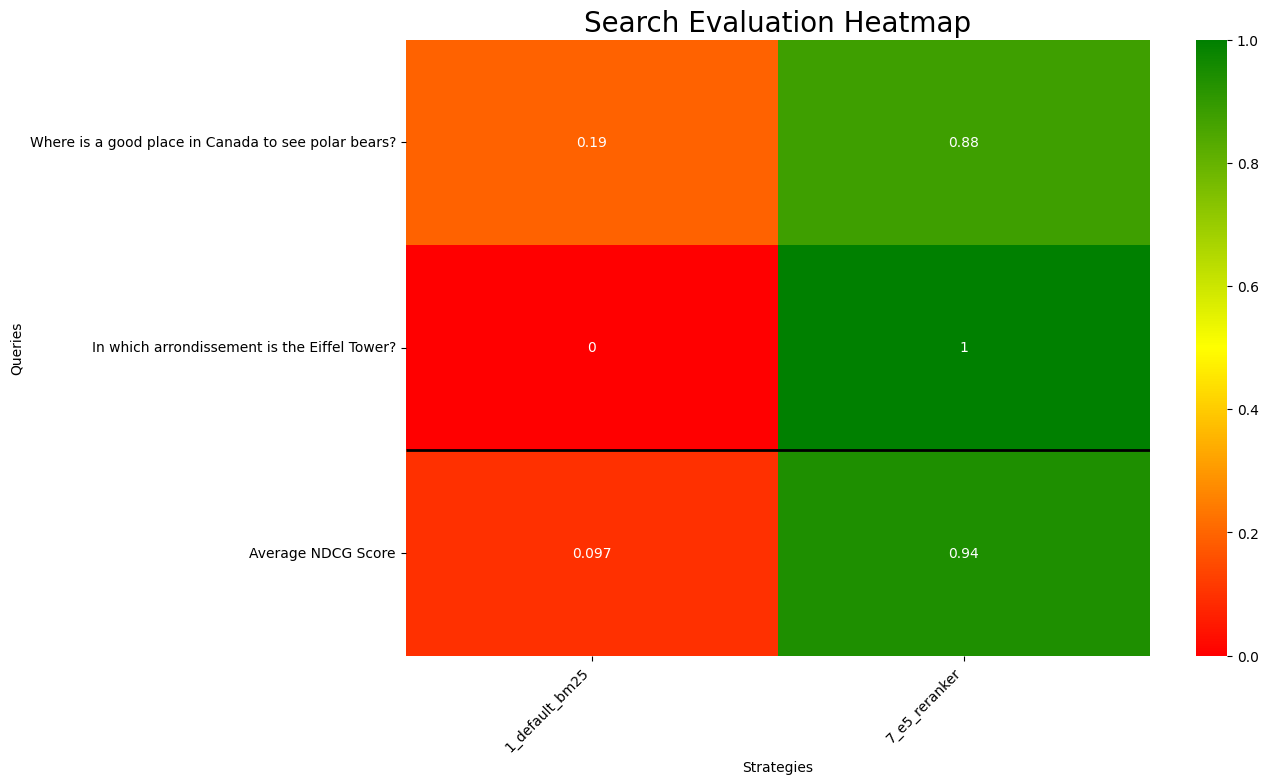

In [4]:
## Visualize the Results of the Evaluation
# 6. Visualize
vis_search_eval_json(SEARCH_OUTPUT_JSON)

In [5]:
from evaluate import run_deepeval, output_deepeval_results

import json

# startegies to Evauate
# include_strategy_names = ["3b_e5_hybrid", "3b_e5_hybrid_qt"]


## Deep Eval Evaluation
print("### DEEP EVAL")
es = get_es()

rag_system_prompt = """
Instructions:

- You are an assistant for question-answering tasks.
- Answer questions truthfully and factually using only the context presented.
- Do not jump to conclusions or make assumptions.
- If the answer is not present in the provided context, just say that you don't know rather than making up an answer or using your own knowledge from outside the prompt.
- You must always cite the document where the answer was extracted using inline academic citation style [], using the position or multiple positions. Example:  [1][3].
- Use markdown format for code examples or bulleted lists.
- You are correct, factual, precise, and reliable.


Context:
{context}
"""

## Search Top 6 documents, with 3 inner hits per doc, send a max of 9 citations to the LLM for RAG
deepEvalScores = run_deepeval(es, strategy_modules, golden_data, rag_system_prompt,6, 3, 9)


## save the scores to disk
output_deepeval_results(DEEPEVAL_OUTPUT_JSON, deepEvalScores)
print(f"\nDeepEval scores saved to {DEEPEVAL_OUTPUT_JSON}")





### DEEP EVAL
Starting strategy: 1_default_bm25
	RAG answer: A good place in Canada to see polar bears is Churchill, Manitoba. It is mentioned as a diving destination where tourists can see Belugas, but it is also well-known for its polar bear population, especially during the fall when the bears move towards the shore waiting for the sea ice to form [3].


I0000 00:00:1743012264.929707 10921847 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


	RAG answer: The Eiffel Tower is located in the 7th arrondissement of Paris.
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 2 test case(s) in parallel: |██████████|100% (2/2) [Time Taken: 00:03,  1.91s/test case]


Starting strategy: 7_e5_reranker
	RAG answer: A good place in Canada to see polar bears is Wapusk National Park in northern Manitoba. It is one of the world's largest known polar bear maternity denning areas and is accessible by helicopter or Tundra Buggy tour from Churchill [1]. Additionally, Wat'chee Lodge, located 55 km south of Churchill, offers guided tours to see polar bears within the denning areas during the denning season (February-March) [2].
	RAG answer: The Eiffel Tower is located in the 7th arrondissement of Paris [1][2].
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 2 test case(s) in parallel: |██████████|100% (2/2) [Time Taken: 00:04,  2.07s/test case]


DeepEval scores saved to results_deepeval_results.json


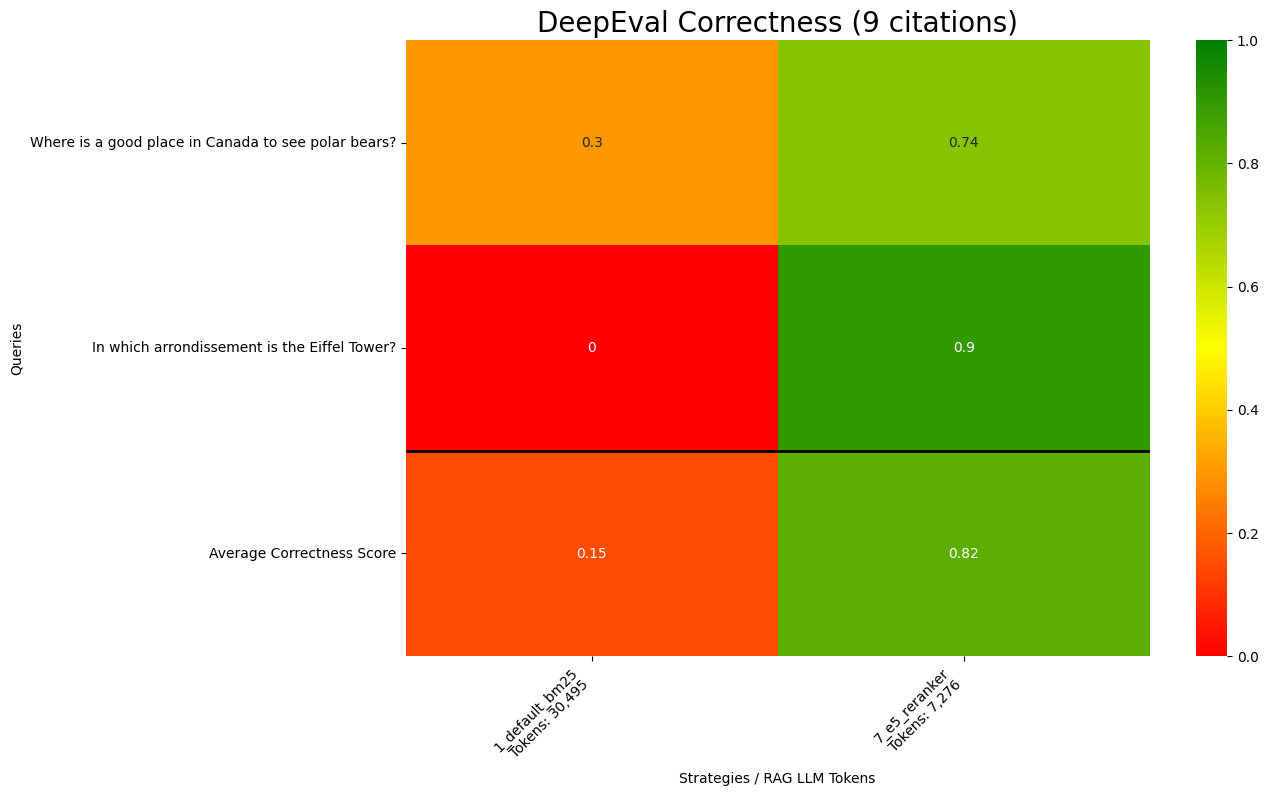

In [6]:
# 6. Visualize
vis_deep_eval_correct_tests(DEEPEVAL_OUTPUT_JSON, "DeepEval Correctness (9 citations)")